In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
from PIL import Image
from tqdm import tqdm
import glob

In [2]:
class DBaodNet(nn.Module):
    def __init__(self):
        super(DBaodNet, self).__init__()
        print("[Model] DerainNet 초기화 중...")

        # ----- K1 브랜치 -----
        self.k1_conv_d1_1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, dilation=1)
        self.k1_bn_d1_1   = nn.BatchNorm2d(16)
        self.k1_conv_d1_2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, dilation=1)
        self.k1_bn_d1_2   = nn.BatchNorm2d(16)
        self.k1_conv_d1_3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, dilation=1)
        self.k1_bn_d1_3   = nn.BatchNorm2d(16)

        self.k1_conv_d2_1 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=2, dilation=2)
        self.k1_bn_d2_1   = nn.BatchNorm2d(16)
        self.k1_conv_d2_2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=3, dilation=3)
        self.k1_bn_d2_2   = nn.BatchNorm2d(16)

        self.k1_conv_d3_1 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=3, dilation=3)
        self.k1_bn_d3_1   = nn.BatchNorm2d(16)
        self.k1_conv_d3_2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=3, dilation=3)
        self.k1_bn_d3_2   = nn.BatchNorm2d(16)

        self.k1_fuse_conv1 = nn.Conv2d(16 * 3, 32, kernel_size=1, stride=1, padding=0)
        self.k1_bn_fuse1   = nn.BatchNorm2d(32)
        self.k1_fuse_conv2 = nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0)
        self.k1_bn_fuse2   = nn.BatchNorm2d(16)

        self.k1_out = nn.Conv2d(16, 3, kernel_size=1, stride=1, padding=0)

        # ----- K2 브랜치 -----
        self.k2_conv_d0 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1, dilation=1)
        self.k2_bn_d0   = nn.BatchNorm2d(8)

        self.k2_conv_d1_1 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1, dilation=1)
        self.k2_bn_d1_1   = nn.BatchNorm2d(16)
        self.k2_conv_d1_2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, dilation=1)
        self.k2_bn_d1_2   = nn.BatchNorm2d(16)
        self.k2_conv_d1_3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, dilation=1)
        self.k2_bn_d1_3  = nn.BatchNorm2d(32)

        self.k2_conv_d2_1 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=2, dilation=2)
        self.k2_bn_d2_1   = nn.BatchNorm2d(16)
        self.k2_conv_d2_2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=2, dilation=2)
        self.k2_bn_d2_2   = nn.BatchNorm2d(16)
        self.k2_conv_d2_3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2, dilation=2)
        self.k2_bn_d2_3  = nn.BatchNorm2d(32)

        self.k2_conv_d3_1 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=3, dilation=3)
        self.k2_bn_d3_1   = nn.BatchNorm2d(16)
        self.k2_conv_d3_2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=3, dilation=3)
        self.k2_bn_d3_2   = nn.BatchNorm2d(16)
        self.k2_conv_d3_3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=3, dilation=3)
        self.k2_bn_d3_3  = nn.BatchNorm2d(32)

        self.k2_fuse_conv1 = nn.Conv2d(32 * 3, 32, kernel_size=1, stride=1, padding=0)
        self.k2_bn_fuse1   = nn.BatchNorm2d(32)
        self.k2_fuse_conv2 = nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0)
        self.k2_bn_fuse2   = nn.BatchNorm2d(16)

        self.k2_out = nn.Conv2d(16, 3, kernel_size=1, stride=1, padding=0)

        self.negative_slope = 0.2  # LeakyReLU 기울기 상수


    def forward(self, x):
        # ========== K1 브랜치 ==========
        f1_1 = F.leaky_relu(self.k1_bn_d1_1(self.k1_conv_d1_1(x)), negative_slope=self.negative_slope)
        f1_2 = F.leaky_relu(self.k1_bn_d1_2(self.k1_conv_d1_2(f1_1)), negative_slope=self.negative_slope)
        f1_3 = F.leaky_relu(self.k1_bn_d1_3(self.k1_conv_d1_3(f1_2)), negative_slope=self.negative_slope)
        f1_f = torch.cat([f1_1, f1_2], dim=1)  

        f2_1 = F.leaky_relu(self.k1_bn_d2_1(self.k1_conv_d2_1(f1_f)), negative_slope=self.negative_slope)
        f2_2 = F.leaky_relu(self.k1_bn_d2_2(self.k1_conv_d2_2(f2_1)), negative_slope=self.negative_slope)
        f2_f = torch.cat([f2_1, f2_2], dim=1)

        f3_1 = F.leaky_relu(self.k1_bn_d3_1(self.k1_conv_d3_1(f2_f)), negative_slope=self.negative_slope)
        f3_2 = F.leaky_relu(self.k1_bn_d3_2(self.k1_conv_d3_2(f3_1)), negative_slope=self.negative_slope)
        fuse1 = torch.cat([f1_3, f2_2,f3_2], dim=1)                   # (B,48,H,W)
        fuse1 = F.relu(self.k1_bn_fuse1(self.k1_fuse_conv1(fuse1))) # (B,32,H,W)
        fuse1 = F.relu(self.k1_bn_fuse2(self.k1_fuse_conv2(fuse1))) # (B,16,H,W)

        K1 = self.k1_out(fuse1)  # (B,3,H,W)

        # ========== K2 브랜치 ==========
        g0 = F.leaky_relu(self.k2_bn_d0(self.k2_conv_d0(x)), negative_slope=self.negative_slope)

        g1 = F.leaky_relu(self.k2_bn_d1_1(self.k2_conv_d1_1(g0)), negative_slope=self.negative_slope)
        g1 = F.leaky_relu(self.k2_bn_d1_2(self.k2_conv_d1_2(g1)), negative_slope=self.negative_slope)
        g1 = F.leaky_relu(self.k2_bn_d1_3(self.k2_conv_d1_3(g1)), negative_slope=self.negative_slope)

        g2 = F.leaky_relu(self.k2_bn_d2_1(self.k2_conv_d2_1(g0)), negative_slope=self.negative_slope)
        g2 = F.leaky_relu(self.k2_bn_d2_2(self.k2_conv_d2_2(g2)), negative_slope=self.negative_slope)
        g2 = F.leaky_relu(self.k2_bn_d2_3(self.k2_conv_d2_3(g2)), negative_slope=self.negative_slope)

        g3 = F.leaky_relu(self.k2_bn_d3_1(self.k2_conv_d3_1(g0)), negative_slope=self.negative_slope)
        g3 = F.leaky_relu(self.k2_bn_d3_2(self.k2_conv_d3_2(g3)), negative_slope=self.negative_slope)
        g3 = F.leaky_relu(self.k2_bn_d3_3(self.k2_conv_d3_3(g3)), negative_slope=self.negative_slope)

        fuse2 = torch.cat([g1, g2, g3], dim=1)                      # (B,48,H,W)
        fuse2 = F.relu(self.k2_bn_fuse1(self.k2_fuse_conv1(fuse2))) # (B,32,H,W)
        fuse2 = F.relu(self.k2_bn_fuse2(self.k2_fuse_conv2(fuse2))) # (B,16,H,W)

        K2 = self.k2_out(fuse2)  # (B,3,H,W)

        

        # ========== 최종 복원 식 ==========
        diff = K1 - K2           # (B,3,H,W)
        clean = diff * x - diff  # (B,3,H,W)

        return clean


In [3]:
def print_model_summary(model, model_name):
    """모델의 파라미터 정보와 총 개수를 출력하는 함수"""
    print(f"========== {model_name} Summary ==========")
    
    # 모델의 각 파라미터 이름과 크기(shape) 출력
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name},  Shape: {param.shape}")
    
    # 전체 파라미터 개수 계산 및 출력
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters: {total_params:,}")
    print("=" * (len(model_name) + 24))
    print("\n")


# 1. AODnet 모델 객체 생성 및 파라미터 확인
model = DBaodNet()
print_model_summary(model, "DBaodNet")

[Model] DerainNet 초기화 중...
========== DBaodNet Summary ==========
Layer: k1_conv_d1_1.weight,  Shape: torch.Size([16, 3, 3, 3])
Layer: k1_conv_d1_1.bias,  Shape: torch.Size([16])
Layer: k1_bn_d1_1.weight,  Shape: torch.Size([16])
Layer: k1_bn_d1_1.bias,  Shape: torch.Size([16])
Layer: k1_conv_d1_2.weight,  Shape: torch.Size([16, 16, 3, 3])
Layer: k1_conv_d1_2.bias,  Shape: torch.Size([16])
Layer: k1_bn_d1_2.weight,  Shape: torch.Size([16])
Layer: k1_bn_d1_2.bias,  Shape: torch.Size([16])
Layer: k1_conv_d1_3.weight,  Shape: torch.Size([16, 16, 3, 3])
Layer: k1_conv_d1_3.bias,  Shape: torch.Size([16])
Layer: k1_bn_d1_3.weight,  Shape: torch.Size([16])
Layer: k1_bn_d1_3.bias,  Shape: torch.Size([16])
Layer: k1_conv_d2_1.weight,  Shape: torch.Size([16, 32, 3, 3])
Layer: k1_conv_d2_1.bias,  Shape: torch.Size([16])
Layer: k1_bn_d2_1.weight,  Shape: torch.Size([16])
Layer: k1_bn_d2_1.bias,  Shape: torch.Size([16])
Layer: k1_conv_d2_2.weight,  Shape: torch.Size([16, 16, 3, 3])
Layer: k1_conv_d

In [4]:
class DehazeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        :param data_dir: train, test, val 폴더 중 하나의 경로 (예: 'dataset2_split/train')
        :param transform: 이미지에 적용할 torchvision.transforms
        """
        self.gt_dir = os.path.join(data_dir, 'gt')
        self.input_dir = os.path.join(data_dir, 'input')
        self.transform = transform
        
        # input 폴더의 파일 목록을 기준으로 삼음
        self.image_files = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        
        input_path = os.path.join(self.input_dir, filename)
        gt_path = os.path.join(self.gt_dir, filename)
        
        # PIL 라이브러리를 사용해 이미지 열기 (RGB 형식으로 변환)
        input_image = Image.open(input_path).convert('RGB')
        gt_image = Image.open(gt_path).convert('RGB')
        
        if self.transform:
            input_image = self.transform(input_image)
            gt_image = self.transform(gt_image)
            
        return input_image, gt_image

In [5]:
# GPU 사용 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# 하이퍼파라미터
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 100

# 데이터셋 경로 (split_dataset.py 실행 후 생성된 폴더)
DATA_DIR = "./dataset_split"
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

# 학습된 모델 가중치를 저장할 경로
MODEL_SAVE_PATH = "./pt/DBaodNet"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

Using device: cuda


In [6]:
# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((360, 240)), # 이미지 크기를 256x256으로 조절 H, W 순서
    transforms.ToTensor()          # 이미지를 PyTorch 텐서로 변환 (0~1 값으로 정규화)
])

# 훈련 데이터셋 및 데이터 로더
train_dataset = DehazeDataset(data_dir=TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# 검증 데이터셋 및 데이터 로더
val_dataset = DehazeDataset(data_dir=VAL_DIR, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"훈련 데이터셋 크기: {len(train_dataset)}개")
print(f"검증 데이터셋 크기: {len(val_dataset)}개")

# 셀 5 실행 후 이 코드를 실행해보세요
try:
    input_img, gt_img = train_dataset[0]
    print("데이터셋 로딩 성공!")
    print("Input 이미지 텐서 모양:", input_img.shape)
    print("GT 이미지 텐서 모양:", gt_img.shape)
except Exception as e:
    print("데이터셋 로딩 중 오류 발생:", e)

훈련 데이터셋 크기: 3543개
검증 데이터셋 크기: 507개
데이터셋 로딩 성공!
Input 이미지 텐서 모양: torch.Size([3, 360, 240])
GT 이미지 텐서 모양: torch.Size([3, 360, 240])


In [7]:
# 모델 인스턴스 생성 및 GPU로 이동
# model = AODnet().to(DEVICE) # 기본 모델을 사용하려면 이 줄의 주석을 해제
model = DBaodNet().to(DEVICE) # PONO 모델 사용
print("Model:", model.__class__.__name__)

# 손실 함수 (Loss Function) - 이미지 복원에는 MSE Loss가 일반적으로 사용됨
criterion = nn.MSELoss()

# 옵티마이저 (Optimizer) - Adam이 안정적이고 좋은 성능을 보임
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

[Model] DerainNet 초기화 중...
Model: DBaodNet


In [13]:
# 각 에폭의 손실 값을 저장할 리스트 생성
train_loss_history = [] # <<< 추가
val_loss_history = []   # <<< 추가

best_val_loss = float('inf')

print("\n===== 모델 학습을 시작합니다 =====")
for epoch in range(NUM_EPOCHS):
    # --- 훈련 단계 ---
    model.train()
    train_loss = 0.0
    
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for hazy_images, clean_images in train_iterator:
        hazy_images = hazy_images.to(DEVICE)
        clean_images = clean_images.to(DEVICE)
        
        outputs = model(hazy_images)
        loss = criterion(outputs, clean_images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item()})
        
    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss) # <<< 추가

    # --- 검증 단계 ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for hazy_images, clean_images in val_iterator:
            hazy_images = hazy_images.to(DEVICE)
            clean_images = clean_images.to(DEVICE)
            
            outputs = model(hazy_images)
            loss = criterion(outputs, clean_images)
            val_loss += loss.item()
            val_iterator.set_postfix({'loss': loss.item()})
            
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss) # <<< 추가
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_file = os.path.join(MODEL_SAVE_PATH, f"best_model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), save_file)
        print(f"***** Best model saved to {save_file} (Val Loss: {best_val_loss:.6f}) *****\n")

print("\n===== 모든 학습이 완료되었습니다! =====")


===== 모델 학습을 시작합니다 =====


Epoch 1/100 [Val]: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s, loss=0.187] 


Epoch [1/100], Train Loss: 0.165244, Val Loss: 0.126547
***** Best model saved to ./pt/DBaodNet\best_model_epoch_1.pth (Val Loss: 0.126547) *****



Epoch 2/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s, loss=0.144] 


Epoch [2/100], Train Loss: 0.108693, Val Loss: 0.096947
***** Best model saved to ./pt/DBaodNet\best_model_epoch_2.pth (Val Loss: 0.096947) *****



Epoch 3/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s, loss=0.117] 


Epoch [3/100], Train Loss: 0.087432, Val Loss: 0.080196
***** Best model saved to ./pt/DBaodNet\best_model_epoch_3.pth (Val Loss: 0.080196) *****



Epoch 4/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s, loss=0.097] 


Epoch [4/100], Train Loss: 0.073890, Val Loss: 0.069022
***** Best model saved to ./pt/DBaodNet\best_model_epoch_4.pth (Val Loss: 0.069022) *****



Epoch 5/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s, loss=0.0825]


Epoch [5/100], Train Loss: 0.066666, Val Loss: 0.062062
***** Best model saved to ./pt/DBaodNet\best_model_epoch_5.pth (Val Loss: 0.062062) *****



Epoch 6/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s, loss=0.0714]


Epoch [6/100], Train Loss: 0.061034, Val Loss: 0.057159
***** Best model saved to ./pt/DBaodNet\best_model_epoch_6.pth (Val Loss: 0.057159) *****



Epoch 7/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s, loss=0.0684]


Epoch [7/100], Train Loss: 0.058593, Val Loss: 0.055819
***** Best model saved to ./pt/DBaodNet\best_model_epoch_7.pth (Val Loss: 0.055819) *****



Epoch 8/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s, loss=0.0568]


Epoch [8/100], Train Loss: 0.056038, Val Loss: 0.051137
***** Best model saved to ./pt/DBaodNet\best_model_epoch_8.pth (Val Loss: 0.051137) *****



Epoch 9/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s, loss=0.0663]


Epoch [9/100], Train Loss: 0.054446, Val Loss: 0.053954


Epoch 10/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s, loss=0.0544]


Epoch [10/100], Train Loss: 0.052742, Val Loss: 0.049127
***** Best model saved to ./pt/DBaodNet\best_model_epoch_10.pth (Val Loss: 0.049127) *****



Epoch 11/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s, loss=0.0485]


Epoch [11/100], Train Loss: 0.050906, Val Loss: 0.046805
***** Best model saved to ./pt/DBaodNet\best_model_epoch_11.pth (Val Loss: 0.046805) *****



Epoch 12/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s, loss=0.0598]


Epoch [12/100], Train Loss: 0.051407, Val Loss: 0.051893


Epoch 13/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s, loss=0.0457]


Epoch [13/100], Train Loss: 0.049620, Val Loss: 0.045681
***** Best model saved to ./pt/DBaodNet\best_model_epoch_13.pth (Val Loss: 0.045681) *****



Epoch 14/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s, loss=0.0539]


Epoch [14/100], Train Loss: 0.049038, Val Loss: 0.048279


Epoch 15/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s, loss=0.0446]


Epoch [15/100], Train Loss: 0.048708, Val Loss: 0.044372
***** Best model saved to ./pt/DBaodNet\best_model_epoch_15.pth (Val Loss: 0.044372) *****



Epoch 16/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s, loss=0.0417]


Epoch [16/100], Train Loss: 0.047128, Val Loss: 0.043147
***** Best model saved to ./pt/DBaodNet\best_model_epoch_16.pth (Val Loss: 0.043147) *****



Epoch 17/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s, loss=0.0416]


Epoch [17/100], Train Loss: 0.047017, Val Loss: 0.043085
***** Best model saved to ./pt/DBaodNet\best_model_epoch_17.pth (Val Loss: 0.043085) *****



Epoch 18/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s, loss=0.0404]


Epoch [18/100], Train Loss: 0.046026, Val Loss: 0.042540
***** Best model saved to ./pt/DBaodNet\best_model_epoch_18.pth (Val Loss: 0.042540) *****



Epoch 19/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s, loss=0.041] 


Epoch [19/100], Train Loss: 0.046643, Val Loss: 0.042229
***** Best model saved to ./pt/DBaodNet\best_model_epoch_19.pth (Val Loss: 0.042229) *****



Epoch 20/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s, loss=0.0362]


Epoch [20/100], Train Loss: 0.046222, Val Loss: 0.040300
***** Best model saved to ./pt/DBaodNet\best_model_epoch_20.pth (Val Loss: 0.040300) *****



Epoch 21/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s, loss=0.0424]


Epoch [21/100], Train Loss: 0.045642, Val Loss: 0.042370


Epoch 22/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s, loss=0.0436]


Epoch [22/100], Train Loss: 0.045373, Val Loss: 0.042505


Epoch 23/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s, loss=0.0428]


Epoch [23/100], Train Loss: 0.044512, Val Loss: 0.041853


Epoch 24/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s, loss=0.0351]


Epoch [24/100], Train Loss: 0.043815, Val Loss: 0.039268
***** Best model saved to ./pt/DBaodNet\best_model_epoch_24.pth (Val Loss: 0.039268) *****



Epoch 25/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s, loss=0.0346]


Epoch [25/100], Train Loss: 0.043887, Val Loss: 0.038915
***** Best model saved to ./pt/DBaodNet\best_model_epoch_25.pth (Val Loss: 0.038915) *****



Epoch 26/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s, loss=0.0441]


Epoch [26/100], Train Loss: 0.042783, Val Loss: 0.042974


Epoch 27/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.08it/s, loss=0.0436]


Epoch [27/100], Train Loss: 0.042715, Val Loss: 0.042204


Epoch 28/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s, loss=0.0405]


Epoch [28/100], Train Loss: 0.043497, Val Loss: 0.040305


Epoch 29/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s, loss=0.0371]


Epoch [29/100], Train Loss: 0.043117, Val Loss: 0.039524


Epoch 30/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s, loss=0.0313]


Epoch [30/100], Train Loss: 0.041772, Val Loss: 0.036811
***** Best model saved to ./pt/DBaodNet\best_model_epoch_30.pth (Val Loss: 0.036811) *****



Epoch 31/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s, loss=0.0426]


Epoch [31/100], Train Loss: 0.041426, Val Loss: 0.040983


Epoch 32/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s, loss=0.0378]


Epoch [32/100], Train Loss: 0.043061, Val Loss: 0.039161


Epoch 33/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s, loss=0.0316]


Epoch [33/100], Train Loss: 0.041090, Val Loss: 0.036703
***** Best model saved to ./pt/DBaodNet\best_model_epoch_33.pth (Val Loss: 0.036703) *****



Epoch 34/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s, loss=0.0328]


Epoch [34/100], Train Loss: 0.040527, Val Loss: 0.037366


Epoch 35/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s, loss=0.0343]


Epoch [35/100], Train Loss: 0.040875, Val Loss: 0.037675


Epoch 36/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s, loss=0.0325]


Epoch [36/100], Train Loss: 0.041007, Val Loss: 0.037580


Epoch 37/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.12it/s, loss=0.0367]


Epoch [37/100], Train Loss: 0.041771, Val Loss: 0.038424


Epoch 38/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s, loss=0.0304]


Epoch [38/100], Train Loss: 0.040543, Val Loss: 0.035536
***** Best model saved to ./pt/DBaodNet\best_model_epoch_38.pth (Val Loss: 0.035536) *****



Epoch 39/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.11it/s, loss=0.0375]


Epoch [39/100], Train Loss: 0.040439, Val Loss: 0.038338


Epoch 40/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s, loss=0.0305]


Epoch [40/100], Train Loss: 0.039902, Val Loss: 0.035002
***** Best model saved to ./pt/DBaodNet\best_model_epoch_40.pth (Val Loss: 0.035002) *****



Epoch 41/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s, loss=0.0386]


Epoch [41/100], Train Loss: 0.040356, Val Loss: 0.039227


Epoch 42/100 [Val]: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s, loss=0.031] 


Epoch [42/100], Train Loss: 0.039459, Val Loss: 0.034335
***** Best model saved to ./pt/DBaodNet\best_model_epoch_42.pth (Val Loss: 0.034335) *****



Epoch 43/100 [Val]: 100%|██████████| 32/32 [00:25<00:00,  1.25it/s, loss=0.0371]


Epoch [43/100], Train Loss: 0.039810, Val Loss: 0.038205


Epoch 44/100 [Val]: 100%|██████████| 32/32 [00:30<00:00,  1.03it/s, loss=0.0274]


Epoch [44/100], Train Loss: 0.038661, Val Loss: 0.033904
***** Best model saved to ./pt/DBaodNet\best_model_epoch_44.pth (Val Loss: 0.033904) *****



Epoch 45/100 [Val]: 100%|██████████| 32/32 [00:08<00:00,  3.89it/s, loss=0.0277]


Epoch [45/100], Train Loss: 0.040564, Val Loss: 0.034728


Epoch 46/100 [Val]: 100%|██████████| 32/32 [00:10<00:00,  3.10it/s, loss=0.0281]


Epoch [46/100], Train Loss: 0.039218, Val Loss: 0.034294


Epoch 47/100 [Val]: 100%|██████████| 32/32 [00:10<00:00,  3.20it/s, loss=0.0368]


Epoch [47/100], Train Loss: 0.039349, Val Loss: 0.037784


Epoch 48/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s, loss=0.028] 


Epoch [48/100], Train Loss: 0.038303, Val Loss: 0.034035


Epoch 49/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s, loss=0.0328]


Epoch [49/100], Train Loss: 0.039122, Val Loss: 0.036059


Epoch 50/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s, loss=0.0268]


Epoch [50/100], Train Loss: 0.038555, Val Loss: 0.033544
***** Best model saved to ./pt/DBaodNet\best_model_epoch_50.pth (Val Loss: 0.033544) *****



Epoch 51/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s, loss=0.0277]


Epoch [51/100], Train Loss: 0.039204, Val Loss: 0.034536


Epoch 52/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s, loss=0.0324]


Epoch [52/100], Train Loss: 0.038702, Val Loss: 0.035644


Epoch 53/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s, loss=0.0283]


Epoch [53/100], Train Loss: 0.039427, Val Loss: 0.034614


Epoch 54/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.19it/s, loss=0.0271]


Epoch [54/100], Train Loss: 0.037913, Val Loss: 0.033251
***** Best model saved to ./pt/DBaodNet\best_model_epoch_54.pth (Val Loss: 0.033251) *****



Epoch 55/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s, loss=0.0517]


Epoch [55/100], Train Loss: 0.038088, Val Loss: 0.043798


Epoch 56/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s, loss=0.0255]


Epoch [56/100], Train Loss: 0.037549, Val Loss: 0.032832
***** Best model saved to ./pt/DBaodNet\best_model_epoch_56.pth (Val Loss: 0.032832) *****



Epoch 57/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s, loss=0.0282]


Epoch [57/100], Train Loss: 0.037329, Val Loss: 0.033915


Epoch 58/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s, loss=0.049] 


Epoch [58/100], Train Loss: 0.038255, Val Loss: 0.043379


Epoch 59/100 [Val]: 100%|██████████| 32/32 [00:11<00:00,  2.89it/s, loss=0.0318]


Epoch [59/100], Train Loss: 0.037249, Val Loss: 0.036183


Epoch 60/100 [Val]: 100%|██████████| 32/32 [00:23<00:00,  1.36it/s, loss=0.0258]


Epoch [60/100], Train Loss: 0.038538, Val Loss: 0.032239
***** Best model saved to ./pt/DBaodNet\best_model_epoch_60.pth (Val Loss: 0.032239) *****



Epoch 61/100 [Val]: 100%|██████████| 32/32 [00:22<00:00,  1.39it/s, loss=0.0294]


Epoch [61/100], Train Loss: 0.037027, Val Loss: 0.034737


Epoch 62/100 [Val]: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s, loss=0.0247]


Epoch [62/100], Train Loss: 0.037194, Val Loss: 0.033306


Epoch 63/100 [Val]: 100%|██████████| 32/32 [00:22<00:00,  1.42it/s, loss=0.0358]


Epoch [63/100], Train Loss: 0.037851, Val Loss: 0.037350


Epoch 64/100 [Val]: 100%|██████████| 32/32 [00:23<00:00,  1.34it/s, loss=0.0282]


Epoch [64/100], Train Loss: 0.037371, Val Loss: 0.033311


Epoch 65/100 [Val]: 100%|██████████| 32/32 [00:21<00:00,  1.50it/s, loss=0.0252]


Epoch [65/100], Train Loss: 0.036333, Val Loss: 0.032736


Epoch 66/100 [Val]: 100%|██████████| 32/32 [00:08<00:00,  3.75it/s, loss=0.028] 


Epoch [66/100], Train Loss: 0.036213, Val Loss: 0.033249


Epoch 67/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s, loss=0.0293]


Epoch [67/100], Train Loss: 0.036335, Val Loss: 0.034425


Epoch 68/100 [Val]: 100%|██████████| 32/32 [00:09<00:00,  3.27it/s, loss=0.0341]


Epoch [68/100], Train Loss: 0.036576, Val Loss: 0.036875


Epoch 69/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s, loss=0.0381]


Epoch [69/100], Train Loss: 0.036849, Val Loss: 0.037900


Epoch 70/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.25it/s, loss=0.0457]


Epoch [70/100], Train Loss: 0.035925, Val Loss: 0.040791


Epoch 71/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s, loss=0.0305]


Epoch [71/100], Train Loss: 0.036771, Val Loss: 0.034436


Epoch 72/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s, loss=0.0272]


Epoch [72/100], Train Loss: 0.036336, Val Loss: 0.033535


Epoch 73/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s, loss=0.0264]


Epoch [73/100], Train Loss: 0.035348, Val Loss: 0.032589


Epoch 74/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s, loss=0.0313]


Epoch [74/100], Train Loss: 0.036169, Val Loss: 0.034731


Epoch 75/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s, loss=0.0422]


Epoch [75/100], Train Loss: 0.035782, Val Loss: 0.038044


Epoch 76/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.17it/s, loss=0.0477]


Epoch [76/100], Train Loss: 0.036771, Val Loss: 0.041748


Epoch 77/100 [Val]: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s, loss=0.0266]


Epoch [77/100], Train Loss: 0.035818, Val Loss: 0.033077


Epoch 78/100 [Val]: 100%|██████████| 32/32 [00:10<00:00,  3.11it/s, loss=0.0313]


Epoch [78/100], Train Loss: 0.035996, Val Loss: 0.033596


Epoch 79/100 [Val]: 100%|██████████| 32/32 [00:25<00:00,  1.27it/s, loss=0.0251]


Epoch [79/100], Train Loss: 0.036394, Val Loss: 0.031481
***** Best model saved to ./pt/DBaodNet\best_model_epoch_79.pth (Val Loss: 0.031481) *****



Epoch 80/100 [Val]: 100%|██████████| 32/32 [00:23<00:00,  1.37it/s, loss=0.0289]


Epoch [80/100], Train Loss: 0.035800, Val Loss: 0.034111


Epoch 81/100 [Val]: 100%|██████████| 32/32 [00:21<00:00,  1.49it/s, loss=0.0282]


Epoch [81/100], Train Loss: 0.035070, Val Loss: 0.031191
***** Best model saved to ./pt/DBaodNet\best_model_epoch_81.pth (Val Loss: 0.031191) *****



Epoch 82/100 [Val]: 100%|██████████| 32/32 [00:21<00:00,  1.52it/s, loss=0.0339]


Epoch [82/100], Train Loss: 0.034958, Val Loss: 0.036147


Epoch 83/100 [Val]: 100%|██████████| 32/32 [00:22<00:00,  1.40it/s, loss=0.0271]


Epoch [83/100], Train Loss: 0.034880, Val Loss: 0.033777


Epoch 84/100 [Val]: 100%|██████████| 32/32 [00:22<00:00,  1.41it/s, loss=0.0297]


Epoch [84/100], Train Loss: 0.035842, Val Loss: 0.034193


Epoch 85/100 [Val]: 100%|██████████| 32/32 [01:21<00:00,  2.53s/it, loss=0.0293]


Epoch [85/100], Train Loss: 0.035183, Val Loss: 0.032550


Epoch 86/100 [Val]: 100%|██████████| 32/32 [00:25<00:00,  1.26it/s, loss=0.0384]


Epoch [86/100], Train Loss: 0.035530, Val Loss: 0.037544


Epoch 87/100 [Val]: 100%|██████████| 32/32 [00:20<00:00,  1.54it/s, loss=0.0279]


Epoch [87/100], Train Loss: 0.035418, Val Loss: 0.033267


Epoch 88/100 [Val]: 100%|██████████| 32/32 [00:23<00:00,  1.39it/s, loss=0.0246]


Epoch [88/100], Train Loss: 0.034638, Val Loss: 0.031807


Epoch 89/100 [Val]: 100%|██████████| 32/32 [00:21<00:00,  1.50it/s, loss=0.0251]


Epoch [89/100], Train Loss: 0.034945, Val Loss: 0.033068


Epoch 90/100 [Val]: 100%|██████████| 32/32 [00:22<00:00,  1.42it/s, loss=0.0271]


Epoch [90/100], Train Loss: 0.035492, Val Loss: 0.032948


Epoch 91/100 [Val]: 100%|██████████| 32/32 [00:23<00:00,  1.37it/s, loss=0.0438]


Epoch [91/100], Train Loss: 0.034492, Val Loss: 0.039527


Epoch 92/100 [Val]: 100%|██████████| 32/32 [00:22<00:00,  1.41it/s, loss=0.0345]


Epoch [92/100], Train Loss: 0.034450, Val Loss: 0.036568


Epoch 93/100 [Val]: 100%|██████████| 32/32 [00:22<00:00,  1.41it/s, loss=0.0241]


Epoch [93/100], Train Loss: 0.033979, Val Loss: 0.031524


Epoch 94/100 [Val]: 100%|██████████| 32/32 [00:21<00:00,  1.51it/s, loss=0.0348]


Epoch [94/100], Train Loss: 0.034718, Val Loss: 0.035262


Epoch 95/100 [Val]: 100%|██████████| 32/32 [00:21<00:00,  1.49it/s, loss=0.028] 


Epoch [95/100], Train Loss: 0.035358, Val Loss: 0.033441


Epoch 96/100 [Val]: 100%|██████████| 32/32 [00:22<00:00,  1.41it/s, loss=0.0255]


Epoch [96/100], Train Loss: 0.034294, Val Loss: 0.031848


Epoch 97/100 [Val]: 100%|██████████| 32/32 [00:28<00:00,  1.10it/s, loss=0.024] 


Epoch [97/100], Train Loss: 0.034606, Val Loss: 0.032001


Epoch 98/100 [Val]: 100%|██████████| 32/32 [00:33<00:00,  1.04s/it, loss=0.0348]


Epoch [98/100], Train Loss: 0.033839, Val Loss: 0.036559


Epoch 99/100 [Val]: 100%|██████████| 32/32 [00:22<00:00,  1.44it/s, loss=0.0291]


Epoch [99/100], Train Loss: 0.033813, Val Loss: 0.033313


Epoch 100/100 [Val]: 100%|██████████| 32/32 [00:24<00:00,  1.28it/s, loss=0.0288]

Epoch [100/100], Train Loss: 0.034217, Val Loss: 0.033264

===== 모든 학습이 완료되었습니다! =====


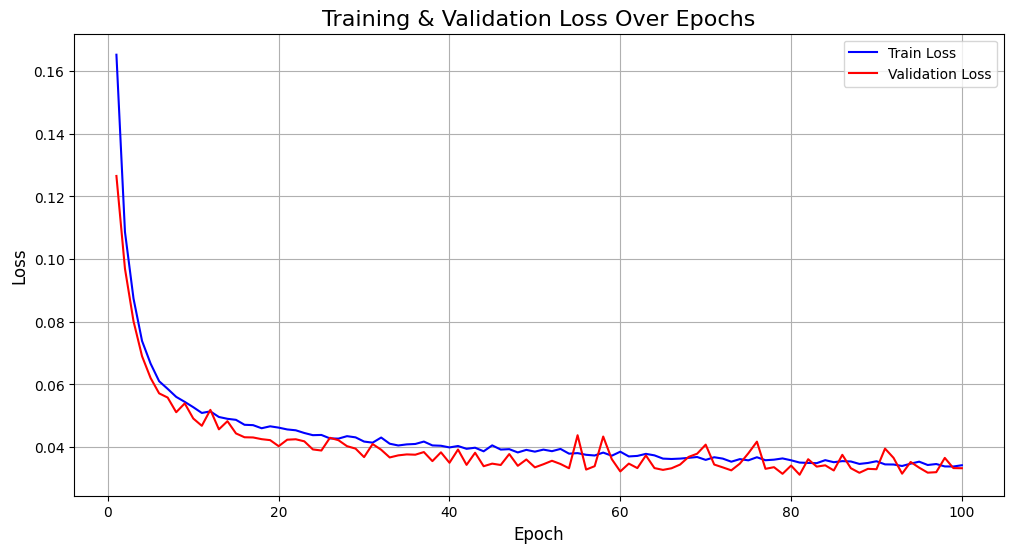

In [15]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 훈련 손실과 검증 손실 그래프 그리기
plt.plot(range(1, NUM_EPOCHS + 1), train_loss_history, label='Train Loss', color='blue')
plt.plot(range(1, NUM_EPOCHS + 1), val_loss_history, label='Validation Loss', color='red')

# 그래프 제목 및 축 레이블 설정
plt.title('Training & Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# 범례 표시
plt.legend()

# 그리드 표시
plt.grid(True)

# 그래프 보여주기
plt.show()

In [8]:
# 새로운 셀

import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 평가에 사용할 테스트셋 폴더 경로
TEST_DIR = os.path.join(DATA_DIR, 'test')

# 2. 불러올 학습된 모델 가중치 파일의 경로
# 'trained_models' 폴더 안에 저장된 .pth 파일 중 가장 성능이 좋았던(best) 모델의 경로를 지정합니다.
MODEL_WEIGHTS_PATH = "pt/DBaodNet/best_model_epoch_81.pth" # XX 부분은 실제 파일 숫자로 변경
# --------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = DBaodNet().to(DEVICE)
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval() # 모델을 반드시 평가 모드로 설정!

# 테스트 데이터 로더 준비
test_dataset = DehazeDataset(data_dir=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0) # num_workers=0으로 설정

# 점수를 저장할 리스트 초기화
psnr_scores = []
ssim_scores = []

print(f"\n===== '{MODEL_WEIGHTS_PATH}' 모델 성능 평가 시작 =====")

# 평가 루프
with torch.no_grad(): # 기울기 계산 비활성화
    for hazy_images, clean_images in tqdm(test_loader, desc="Evaluating"):
        hazy_images = hazy_images.to(DEVICE)
        
        # 모델 추론
        outputs = evaluation_model(hazy_images)
        
        # GPU 텐서를 CPU의 Numpy 배열로 변환 (skimage 계산용)
        # (B, C, H, W) -> (B, H, W, C) 형태로 변경 및 0-255 범위의 정수형으로 변환
        outputs_np = outputs.cpu().permute(0, 2, 3, 1).numpy() * 255
        clean_images_np = clean_images.cpu().permute(0, 2, 3, 1).numpy() * 255
        
        outputs_np = outputs_np.astype(np.uint8)
        clean_images_np = clean_images_np.astype(np.uint8)
        
        # 배치 내의 각 이미지에 대해 점수 계산
        for i in range(clean_images_np.shape[0]):
            gt_image = clean_images_np[i]
            pred_image = outputs_np[i]
            
            # PSNR 계산
            psnr = peak_signal_noise_ratio(gt_image, pred_image, data_range=255)
            psnr_scores.append(psnr)
            
            # SSIM 계산
            # channel_axis=-1 은 컬러 이미지(RGB)의 채널 축을 지정해줍니다.
            ssim = structural_similarity(gt_image, pred_image, channel_axis=-1, data_range=255)
            ssim_scores.append(ssim)

# 평균 점수 계산
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)

print("\n===== 평가 완료 =====")
print(f"테스트 데이터셋 평균 PSNR: {avg_psnr:.4f} dB")
print(f"테스트 데이터셋 평균 SSIM: {avg_ssim:.4f}")

[Model] DerainNet 초기화 중...

===== 'pt/DBaodNet/best_model_epoch_81.pth' 모델 성능 평가 시작 =====


Evaluating: 100%|██████████| 127/127 [00:29<00:00,  4.28it/s]


===== 평가 완료 =====
테스트 데이터셋 평균 PSNR: 15.0881 dB
테스트 데이터셋 평균 SSIM: 0.6119


[Model] DerainNet 초기화 중...
이미지 복원을 시작합니다...
'dataset_split/test/input/51_rain.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/im_0048_s95_a06.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/NYU2_1331.jpg' 복원 및 정답 이미지 로드 완료.


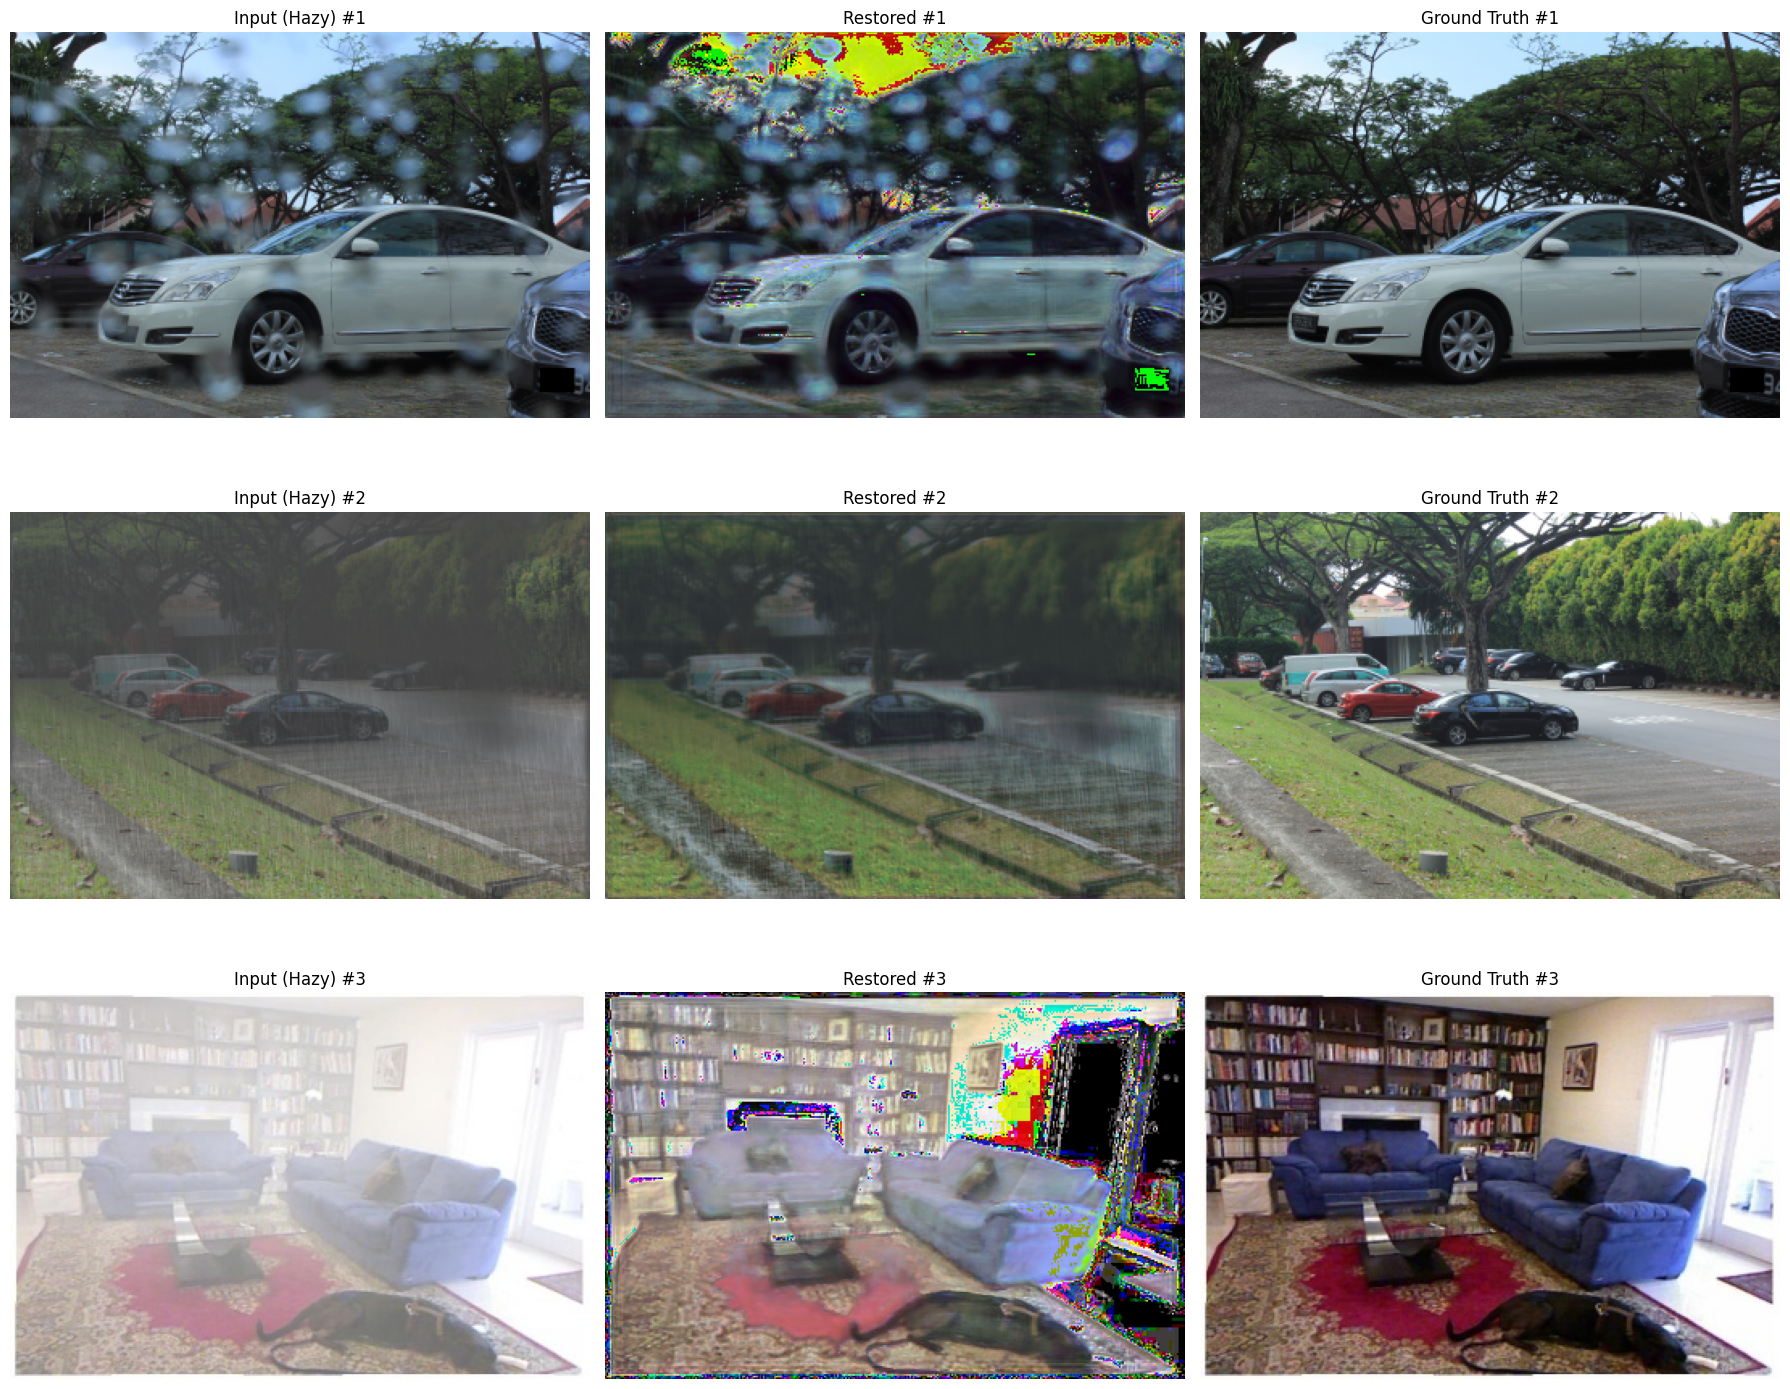


이미지 복원 및 비교 완료!


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import os

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 불러올 학습된 모델 가중치 파일의 경로
MODEL_WEIGHTS_PATH = "pt/DBaodNet/best_model_epoch_81.pth"

# 2. 복원할 안개 이미지(input) 파일 경로들을 리스트 형태로 지정
HAZY_IMAGE_PATHS = [
    "dataset_split/test/input/51_rain.png",
    "dataset_split/test/input/im_0048_s95_a06.png",
    "dataset_split/test/input/NYU2_1331.jpg"
]

# 3. 정답 이미지(gt)가 들어있는 폴더 경로
GT_BASE_DIR = "dataset_split/test/gt"

# 4. 모델 학습 시 사용했던 이미지 해상도
TARGET_IMAGE_SIZE = (240, 360)
# ----------------------------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = DBaodNet().to(DEVICE) # DEVICE는 이전 셀에서 정의됨
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval()

# 이미지 전처리 transform 정의
transform = transforms.Compose([
    transforms.Resize(TARGET_IMAGE_SIZE),
    transforms.ToTensor()
])

# 결과를 저장할 리스트 생성
hazy_images_pil = []
restored_images_pil = []
clean_images_pil = []

print("이미지 복원을 시작합니다...")

for hazy_path in HAZY_IMAGE_PATHS:
    try:
        filename = os.path.basename(hazy_path)
        
        # ★★★ 수정된 부분 ★★★
        # os.path.join으로 생성된 경로를 os.path.normpath로 정규화
        clean_path_raw = os.path.join(GT_BASE_DIR, filename)
        clean_path = os.path.normpath(clean_path_raw)
        
        if not os.path.exists(clean_path):
            print(f"경고: 짝이 되는 정답 이미지 '{clean_path}'를 찾을 수 없습니다. 건너뜁니다.")
            continue

        hazy_image = Image.open(hazy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')
        
        hazy_tensor = transform(hazy_image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            restored_tensor = evaluation_model(hazy_tensor)

        restored_image = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())

        hazy_images_pil.append(hazy_image)
        restored_images_pil.append(restored_image)
        clean_images_pil.append(clean_image)
        print(f"'{hazy_path}' 복원 및 정답 이미지 로드 완료.")

    except FileNotFoundError:
        print(f"오류: '{hazy_path}' 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요.")
    except Exception as e:
        print(f"'{hazy_path}' 처리 중 오류 발생: {e}")

# --- 시각화 부분 ---
if hazy_images_pil:
    num_images = len(hazy_images_pil)
    # 3개의 행(이미지 쌍), 3개의 열(Input, Restored, GT)
    plt.figure(figsize=(18, 5 * num_images)) 

    for i in range(num_images):
        # --- i번째 이미지 쌍 ---
        
        # 1열: 입력(Hazy) 이미지
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(hazy_images_pil[i])
        plt.title(f'Input (Hazy) #{i+1}')
        plt.axis('off')

        # 2열: 복원된 이미지
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(restored_images_pil[i])
        plt.title(f'Restored #{i+1}')
        plt.axis('off')
        
        # 3열: 정답(GT) 이미지
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(clean_images_pil[i])
        plt.title(f'Ground Truth #{i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("\n이미지 복원 및 비교 완료!")

In [ ]:
# 객체 탐지 추가 yolo 사용